# Framework which calculates result of algorithm and plots it

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import localtime, strftime

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

In [4]:
# Number of samples in each class

TEST_SAMPLE_NUMBER = 57092
TRAIN_SAMPLE_NUMBER = 285998

# array1: [sX1; sY1; sX2; sY2; ...]
# array2: [eX1; eY1; eX2; eY2; ...]
# output: [dist((sX1, sY1), (eX1, eY1)), dist((sX1, sY1), (eX1, eY1)),
#          dist((sX2, sY2), (eX2, eY2)), dist((sX2, sY2), (eX2, eY2)), ...]

def distance_for_each_point(array1, array2):
    assert (len(array1) == len(array2)), "Arrays' sizes have to be equal (array1: {}, array2: {})".format(
        len1=len(array1), len2=len(array2))
    
    array_length = len(array1)
    
    # for one-dimension arrays np.linalg.norm works in one way and for two-dimension in other
    if array1.ndim == 1:
        # array1[i:i+2] -- point i from first array
        # np.linalg.norm -- calculate distance between points
        distance = np.array([np.linalg.norm(array1[i:i+2] - array2[i:i+2]) for i in range(0,array_length,2)])
        result = np.array([[d, d] for d in distance]).flatten()
    else:
        result = np.array([distance_for_each_point(array1[i], array2[i]) for i in range(array_length)])
    
    return result

# metrics between real results (in tests) and predicted
def distance(test_results, predicted_results):
    return distance_for_each_point(np.array(test_results), predicted_results).sum() / TEST_SAMPLE_NUMBER / 2

# data may be present as [n_features * n_samples] or [n_samples * n_features] 
# usually algorithms require second variant but I prefer first
def to_model(df):
    return np.array(df).T

# you need to pass as arguments function to execute, test_results to compare with predicted by function,
# parameter_name to know results by which parameter you want to compare and list_of_values for this parameter
# also you need to pass other argument which function will use 
# it's always some test_data and usually train_data and train_results
def framework(function, test_results, parameter_name, list_of_values, **other_parameters):
    log_file_name = "src/Logs/{date}_predicted_coordinates_{function_name}_{parameter_name}_".format(
        date=strftime("%Y%m%d", localtime()), function_name=function.__name__, parameter_name=parameter_name)
    plot_file_name = "src/Plots/{date}_{function_name}_difference_by_{parameter_name}.png".format(
        date=strftime("%Y%m%d", localtime()), function_name=function.__name__, parameter_name=parameter_name)
    
    # we will keep results for each configuration here
    result = []

    for i, value in enumerate(list_of_values):
        print("{cur}/{num}: {time}".format(cur=i+1, num=len(list_of_values),
                                           time=strftime("%Y-%m-%d %H:%M:%S", localtime())))
        other_parameters[parameter_name] = value        
        predicted_results = function(**other_parameters)
        np.save(log_file_name + str(value), predicted_results)
        result.append(distance(test_results, predicted_results))
        
    print("done! {time}".format(time=strftime("%Y-%m-%d %H:%M:%S", localtime())))
    print("Results: {}".format(result))
        
    ind = list_of_values
    number = len(ind)
    width = 2 / number
    result_bar = plt.bar(range(number), result, width, color='g')

    plt.ylabel('Average difference')
    plt.xlabel(parameter_name)
    plt.title("Difference between real points and predicted by {parameter_name} in {function_name}".format(
        function_name=function.__name__, parameter_name=parameter_name))
    plt.xticks(np.array(range(number)) + width/2, ind)
    plt.savefig(plot_file_name)    

In [3]:
# reading data from .csv files

test_data = pd.read_csv('src/test_data_points.csv', index_col=0)
train_data = pd.read_csv('src/train_data_points.csv', index_col=0)

# split ten frames in input and output data (we want to predict output by input)

test_results = test_data[5:10]
test_data = test_data[:5]

train_results = train_data[5:10]
train_data = train_data[:5]

In [5]:
# first simply algorithm to get some start
# more about it you can find in 'baseline_distance_between_real_points_and_predicted.ipynb'
def baseline(dataframe, start_point_index=0, number_of_points_to_return=5):
    error_template = "Start point index should be less than last point. Start point index: {st}, last point index: {end}"
    assert (start_point_index < len(dataframe) - 1), error_template.format(st=start_point_index, end=len(dataframe) - 1)
    
    start_point = np.array(dataframe)[start_point_index]
    last_but_one_point = np.array(dataframe)[-2]
    end_point = np.array(dataframe)[-1]
    
    distance = distance_for_each_point(end_point, start_point)
    normalized_motion_vector = (end_point - start_point) / distance
    normalized_motion_vector[np.where(distance == 0)] = 0
    last_vector_length = distance_for_each_point(end_point, last_but_one_point)
    
    motion_vector = normalized_motion_vector * last_vector_length
    result = [end_point + motion_vector * (i+1) for i in range(number_of_points_to_return)]
        
    return np.array(result)

1/4: 2016-10-10 21:00:10
2/4: 2016-10-10 21:00:33
3/4: 2016-10-10 21:00:55
4/4: 2016-10-10 21:01:17
done! 2016-10-10 21:01:40
Results: [132.88285542585496, 129.96077777872861, 127.77554862329157, 130.34267923441266]


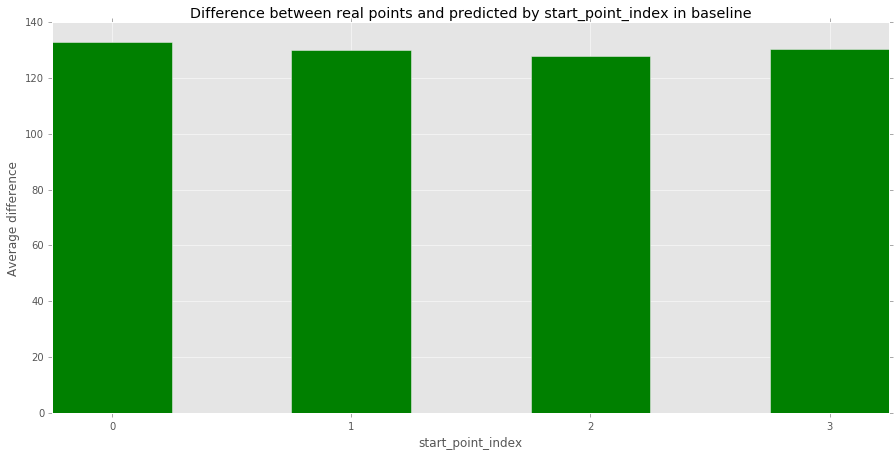

In [5]:
framework(function=baseline, test_results=test_results, parameter_name="start_point_index", list_of_values=range(4),
          dataframe=test_data)

In [6]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_regressor(n_estimators, train_data, train_results, test_data):
    est = RandomForestRegressor(n_estimators=n_estimators)
    est.fit(to_model(train_data), to_model(train_results))
    return (est.predict(to_model(test_data))).T

1/4: 2016-10-10 21:01:50
2/4: 2016-10-10 21:04:27
3/4: 2016-10-10 21:09:24
4/4: 2016-10-10 21:16:18
done! 2016-10-10 21:25:48
Results: [122.14187039600647, 119.22261250368635, 117.9822535230978, 117.42256582009219]


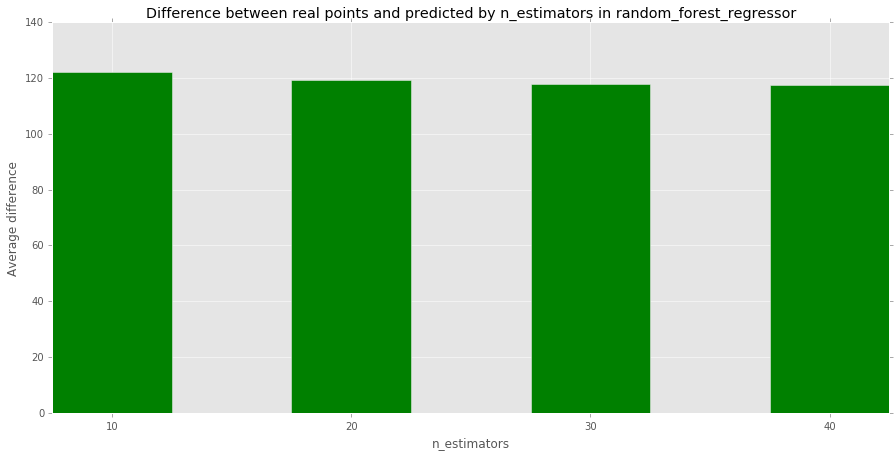

In [7]:
framework(function=random_forest_regressor, test_results=test_results, parameter_name="n_estimators",
          list_of_values=range(10, 50, 10), train_data=train_data, train_results=train_results, test_data=test_data)

In [8]:
from sklearn.neighbors import KNeighborsRegressor

# n_neighbors by defalt is 5;         to compare: range(5, 55, 5)
# weights     by defalt is 'uniform'; to compare: ['uniform', 'distance']
# algorithm   by defalt is 'auto';    to compare: ['auto', 'ball_tree', 'kd_tree', 'brute']
# note: 'brute' is causing some memory error

def kneighbors_regressor(train_data, train_results, test_data, **kwargs):
    neigh = KNeighborsRegressor(**kwargs)
    neigh.fit(to_model(train_data), to_model(train_results))
    return (neigh.predict(to_model(test_data))).T

1/10: 2016-10-10 21:26:01
2/10: 2016-10-10 21:26:36
3/10: 2016-10-10 21:27:10
4/10: 2016-10-10 21:27:46
5/10: 2016-10-10 21:28:23
6/10: 2016-10-10 21:29:01
7/10: 2016-10-10 21:29:39
8/10: 2016-10-10 21:30:16
9/10: 2016-10-10 21:30:58
10/10: 2016-10-10 21:31:40
done! 2016-10-10 21:32:19
Results: [121.71595940399732, 116.88186981137628, 115.7455282226525, 115.42288604192073, 115.41927496876723, 115.55099261492231, 115.74464158811347, 115.92505170617173, 116.13539884732155, 116.36552833207047]


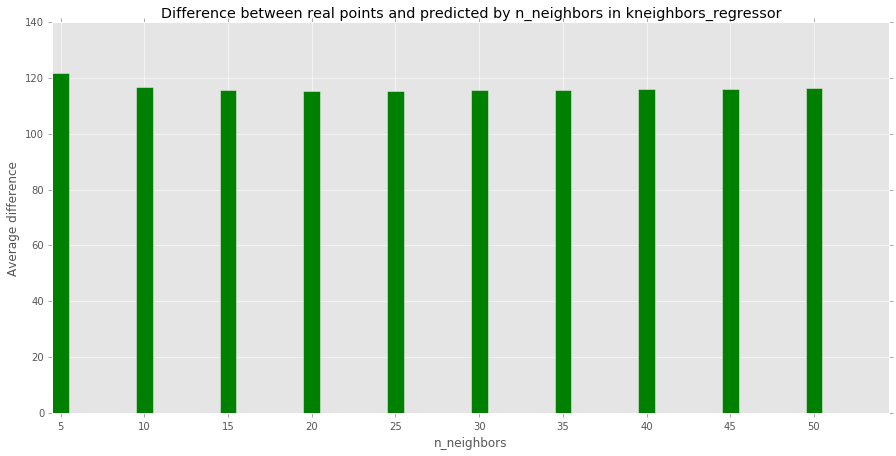

In [9]:
framework(function=kneighbors_regressor, test_results=test_results, parameter_name="n_neighbors",
          list_of_values=range(5, 55, 5), train_data=train_data, train_results=train_results, test_data=test_data)

1/2: 2016-10-10 21:32:21
2/2: 2016-10-10 21:32:50
done! 2016-10-10 21:33:19
Results: [121.71595940399732, 121.87524832566734]


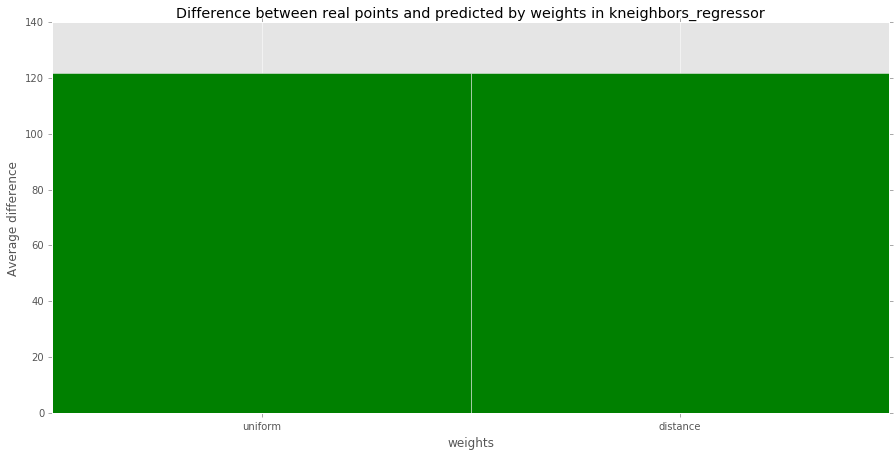

In [10]:
framework(function=kneighbors_regressor, test_results=test_results, parameter_name="weights",
          list_of_values=['uniform', 'distance'], train_data=train_data, train_results=train_results, test_data=test_data)

1/2: 2016-10-10 21:33:20
2/2: 2016-10-10 21:36:59
done! 2016-10-10 21:37:31
Results: [121.71222860117132, 121.71595940399732]


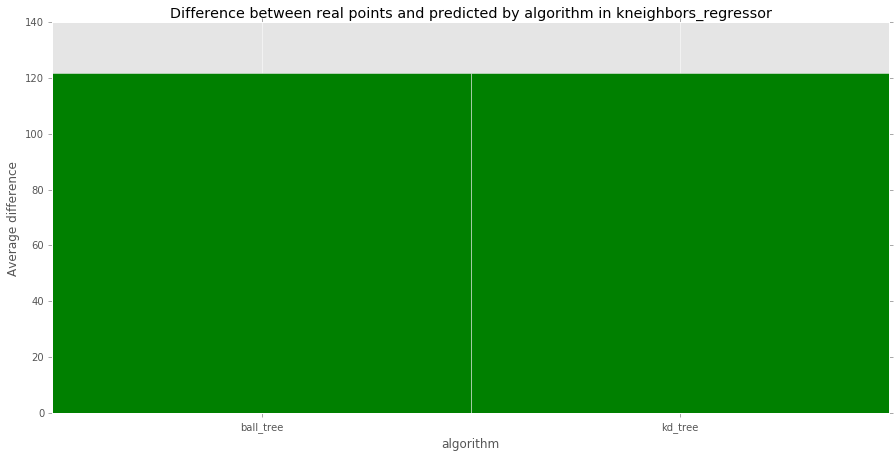

In [11]:
framework(function=kneighbors_regressor, test_results=test_results, parameter_name="algorithm",
          list_of_values=['ball_tree', 'kd_tree'], train_data=train_data, train_results=train_results,
          test_data=test_data)

As we can see there is no difference which algorithm to use: ball_tree or kd_tree but kd_tree works faster.

Also between 'uniform' and 'distance' (parameter weights) there is no difference neither.